In [27]:
# config.py

GAME_CONFIG = {
    # --- MAP SETTINGS ---
    "num_nodes": 26,
    "max_rounds": 100,
    "home_a": 1,
    "home_b": 14,
    "power_nodes": [4, 7, 11, 17, 20, 24],
    
    # --- ECONOMY ---
    "harvest_home": 5,         # Income from Home Base
    "harvest_power": 5,        # Income from Power Node
    "harvest_normal": 1,       # Income from Normal Node
    
    # --- COSTS ---
    "cost_expand_normal": 5,
    "cost_expand_power": 15,
    "cost_conquer_normal_base": 8,
    "cost_conquer_power_base": 20,
    
    # --- COMBAT MECHANICS ---
    "collision_penalty": 5,         # Energy lost by loser (or both if tie) in expansion conflict
    "defense_bonus_per_neighbor": 1 # Extra cost per neighbor owned by defender
}

In [28]:
# strategies.py
import random

# --- HELPER: Safe Target Filter ---
def get_valid_targets(targets):
    # Exclude Home Bases (1 and 14) from potential target lists
    # This fixes the "Target Fixation Bug"
    return [t for t in targets if t not in [1, 14]]

# --- STRATEGY 1: RANDOM (Smart Random) ---
def strat_random(free, opp, mine, energy):
    actions = ["HARVEST"]
    
    # 1. EXPANSION
    if free and energy >= 5:
        power_nodes = [4, 7, 11, 17, 20, 24]
        available_power = [n for n in free if n in power_nodes]
        available_normal = [n for n in free if n not in power_nodes]
        
        possible_targets = []
        if available_power and energy >= 16: possible_targets.extend(available_power)
        if available_normal and energy >= 5: possible_targets.extend(available_normal)
            
        if possible_targets:
            target = random.choice(possible_targets)
            cost = 15 if target in power_nodes else 5
            if energy >= cost: return ["EXPAND", target]

    # 2. CONQUEST
    valid_opp = get_valid_targets(opp)
    if not free and valid_opp:
        affordable_targets = []
        for t in valid_opp:
            base = 20 if t in [4, 7, 11, 17, 20, 24] else 8
            if energy >= base + 1: affordable_targets.append(t)
        
        if affordable_targets: return ["CONQUER", random.choice(affordable_targets)]

    return ["HARVEST"]

# --- STRATEGY 2: POWER RUSHER (The Overbidder) ---
def strat_power_rush(free, opp, mine, energy):
    power_nodes = [4, 7, 11, 17, 20, 24]
    free_power = [n for n in free if n in power_nodes]
    
    if free_power:
        if energy >= 16: return ["EXPAND", random.choice(free_power)]
        elif energy >= 5 and energy < 15:
            if len(free_power) > 2:
                normal_nodes = [n for n in free if n not in power_nodes]
                if normal_nodes: return ["EXPAND", random.choice(normal_nodes)]
        return ["HARVEST"]

    if free and energy >= 5: return ["EXPAND", free[0]]
        
    opp_power = [n for n in get_valid_targets(opp) if n in power_nodes]
    if opp_power and energy >= 25: return ["CONQUER", opp_power[0]]

    return ["HARVEST"]

# --- STRATEGY 3: THE HOARDER (The Capitalist) ---
def strat_hoarder(free, opp, mine, energy):
    if energy >= 16 and free:
        power_nodes = [4, 7, 11, 17, 20, 24]
        free_power = [n for n in free if n in power_nodes]
        if free_power: return ["EXPAND", free_power[0]]
        else: return ["EXPAND", free[0]]

    if energy >= 6 and energy < 15:
        normal_nodes = [n for n in free if n not in [4, 7, 11, 17, 20, 24]]
        if normal_nodes: return ["EXPAND", normal_nodes[0]]
             
    valid_opp = get_valid_targets(opp)
    if energy > 30 and valid_opp:
        return ["CONQUER", valid_opp[0]]

    return ["HARVEST"]

# --- STRATEGY 4: THE NEIGHBOR (The Fortress Builder) ---
def strat_neighbor(free, opp, mine, energy):
    def get_neighbors(n): return [n-1 if n>1 else 26, n+1 if n<26 else 1]

    high_value_targets = []
    normal_targets = []
    
    for node in free:
        neighbors = get_neighbors(node)
        my_neighbors = sum(1 for n in neighbors if n in mine)
        if my_neighbors > 0:
            if node in [4, 7, 11, 17, 20, 24]: high_value_targets.append(node)
            elif my_neighbors == 2: normal_targets.insert(0, node) 
            else: normal_targets.append(node)

    if high_value_targets and energy >= 16: return ["EXPAND", high_value_targets[0]]
    if normal_targets and energy >= 5: return ["EXPAND", normal_targets[0]]
    if free and energy >= 5 and not mine: return ["EXPAND", random.choice(free)]

    return ["HARVEST"]

# --- STRATEGY 5: THE SNIPER (The Eco-Terrorist) ---
def strat_sniper(free, opp, mine, energy):
    def get_neighbors(n): return [n-1 if n>1 else 26, n+1 if n<26 else 1]
    
    valid_opp = get_valid_targets(opp)
    
    if valid_opp and energy >= 10:
        isolated_targets = []
        for t in valid_opp:
            neighbors = get_neighbors(t)
            defense = sum(1 for n in neighbors if n in opp)
            if defense == 0 and t not in [4, 7, 11, 17, 20, 24]: isolated_targets.append(t)
        if isolated_targets: return ["CONQUER", isolated_targets[0]]

    opp_power = [n for n in valid_opp if n in [4, 7, 11, 17, 20, 24]]
    if opp_power and energy >= 25: return ["CONQUER", opp_power[0]]

    if free and energy >= 5: return ["EXPAND", free[0]]
        
    return ["HARVEST"]

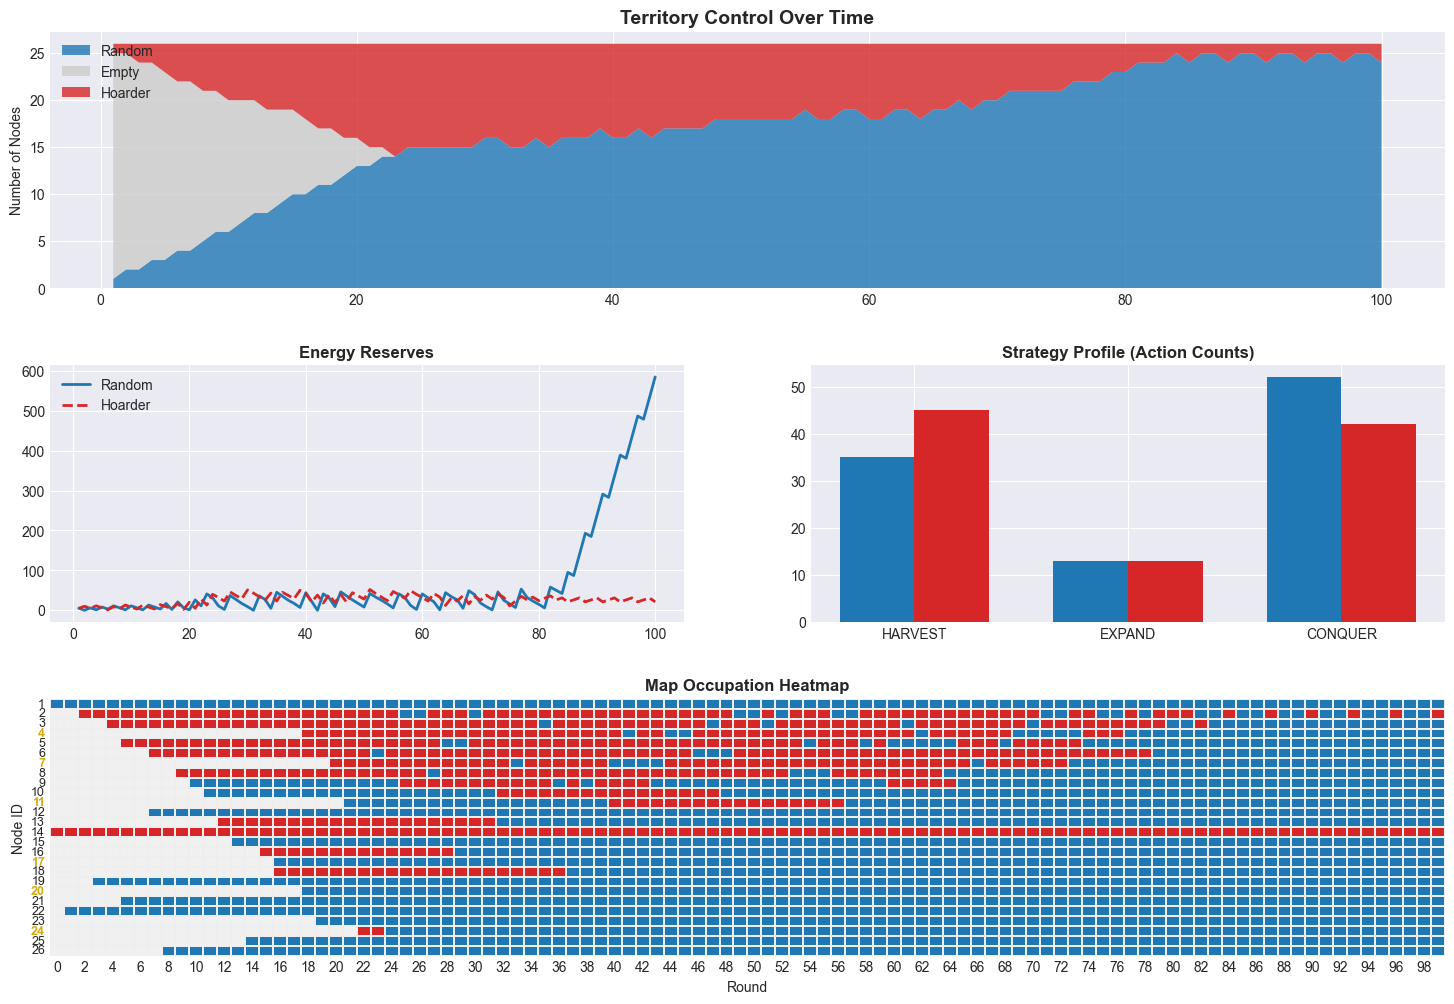

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

class GameSimRecorded:
    def __init__(self, strat_a, strat_b, config=GAME_CONFIG):
        self.config = config
        self.strat_a = strat_a
        self.strat_b = strat_b
        
        # Initialize State
        self.nodes = {i: None for i in range(1, self.config["num_nodes"] + 1)}
        self.energy = {'A': 0, 'B': 0}
        self.nodes[self.config["home_a"]] = 'A'
        self.nodes[self.config["home_b"]] = 'B'
        
        # Metrics Log
        self.metrics = {
            "round": [], "score_a": [], "score_b": [],
            "energy_a": [], "energy_b": [],
            "move_a": [], "move_b": [],
            "nodes_a": [], "nodes_b": []
        }

    def get_neighbors(self, node_id):
        n = self.config["num_nodes"]
        prev_n = node_id - 1 if node_id > 1 else n
        next_n = node_id + 1 if node_id < n else 1
        return [prev_n, next_n]

    def get_node_cost(self, node_id, mode="EXPAND"):
        """Centralized cost calculator to prevent inconsistencies."""
        is_power = node_id in self.config["power_nodes"]
        if mode == "EXPAND":
            return self.config["cost_expand_power"] if is_power else self.config["cost_expand_normal"]
        if mode == "CONQUER":
            return self.config["cost_conquer_power_base"] if is_power else self.config["cost_conquer_normal_base"]
        return 0

    def calculate_defense(self, target_node, defender_id):
        bonus = 0
        for n in self.get_neighbors(target_node):
            if self.nodes[n] == defender_id:
                bonus += self.config["defense_bonus_per_neighbor"]
        return bonus

    def get_view(self, player_id):
        free = [k for k, v in self.nodes.items() if v is None]
        mine = [k for k, v in self.nodes.items() if v == player_id]
        opp_id = 'B' if player_id == 'A' else 'A'
        opp = [k for k, v in self.nodes.items() if v == opp_id]
        return free, opp, mine, self.energy[player_id]

    def resolve_harvest(self, player_id):
        income = 0
        home_node = self.config["home_a"] if player_id == 'A' else self.config["home_b"]
        for n, owner in self.nodes.items():
            if owner == player_id:
                if n == home_node: 
                    income += self.config["harvest_home"]
                elif n in self.config["power_nodes"]: 
                    income += self.config["harvest_power"]
                else: 
                    income += self.config["harvest_normal"]
        return income

    def validate_move(self, move, player_id, free, opp, energy):
        if not move or not isinstance(move, list): return False
        action = move[0]
        if action == "HARVEST": return True
        
        try:
            target = move[1]
        except IndexError:
            return False

        if action == "EXPAND":
            cost = self.get_node_cost(target, "EXPAND")
            return target in free and energy >= cost
            
        if action == "CONQUER":
            # Protect Home Bases
            if target in [self.config["home_a"], self.config["home_b"]]:
                return False
            if target not in opp:
                return False 
                
            opp_id = 'B' if player_id == 'A' else 'A'
            total_cost = self.get_node_cost(target, "CONQUER") + self.calculate_defense(target, opp_id)
            return energy >= total_cost

        return False

    def run_round(self, round_num):
        # 1. Snapshot state for strategies
        free_a, opp_a, mine_a, eng_a = self.get_view('A')
        free_b, opp_b, mine_b, eng_b = self.get_view('B')
        
        # 2. Collect and Validate moves
        move_a = self.strat_a(free_a, opp_a, mine_a, eng_a)
        move_b = self.strat_b(free_b, opp_b, mine_b, eng_b)

        if not self.validate_move(move_a, 'A', free_a, opp_a, eng_a): move_a = ["HARVEST"]
        if not self.validate_move(move_b, 'B', free_b, opp_b, eng_b): move_b = ["HARVEST"]

        resolved = {'A': False, 'B': False}

        # 3. Resolve Expansion Collisions (Highest Energy Wins)
        if move_a[0] == "EXPAND" and move_b[0] == "EXPAND" and move_a[1] == move_b[1]:
            target = move_a[1]
            cost = self.get_node_cost(target, "EXPAND")
            penalty = self.config["collision_penalty"]

            if self.energy['A'] > self.energy['B']:
                self.nodes[target] = 'A'
                self.energy['A'] -= cost
                self.energy['B'] = max(0, self.energy['B'] - penalty)
            elif self.energy['B'] > self.energy['A']:
                self.nodes[target] = 'B'
                self.energy['B'] -= cost
                self.energy['A'] = max(0, self.energy['A'] - penalty)
            else:
                # Tie: Both pay penalty, node remains free
                self.energy['A'] = max(0, self.energy['A'] - penalty)
                self.energy['B'] = max(0, self.energy['B'] - penalty)
            
            resolved['A'] = resolved['B'] = True

        # 4. Resolve Independent Actions
        for p, move in [('A', move_a), ('B', move_b)]:
            if resolved[p]: continue
                
            action = move[0]
            if action == "HARVEST":
                self.energy[p] += self.resolve_harvest(p)
                
            elif action == "EXPAND":
                target = move[1]
                self.nodes[target] = p
                self.energy[p] -= self.get_node_cost(target, "EXPAND")
                
            elif action == "CONQUER":
                target = move[1]
                opp_id = 'B' if p == 'A' else 'A'
                total_cost = self.get_node_cost(target, "CONQUER") + self.calculate_defense(target, opp_id)
                self.nodes[target] = p
                self.energy[p] -= total_cost

        # 5. Record state
        self.metrics["round"].append(round_num)
        self.metrics["score_a"].append(len([v for v in self.nodes.values() if v == 'A']))
        self.metrics["score_b"].append(len([v for v in self.nodes.values() if v == 'B']))
        self.metrics["energy_a"].append(self.energy['A'])
        self.metrics["energy_b"].append(self.energy['B'])
        self.metrics["move_a"].append(move_a[0])
        self.metrics["move_b"].append(move_b[0])
        self.metrics["nodes_a"].append([k for k, v in self.nodes.items() if v == 'A'])
        self.metrics["nodes_b"].append([k for k, v in self.nodes.items() if v == 'B'])

    def play_game(self):
        for r in range(1, self.config["max_rounds"] + 1):
            self.run_round(r)
        return pd.DataFrame(self.metrics)

def plot_game_analysis(df, name_a, name_b, config=GAME_CONFIG):
    plt.style.use('seaborn-v0_8-darkgrid')
    fig = plt.figure(figsize=(18, 12))
    grid = plt.GridSpec(3, 2, hspace=0.3, wspace=0.2)
    col_a, col_b, col_neut = '#1f77b4', '#d62728', '#cccccc'

    # 1. Territory Stacked Plot
    ax1 = fig.add_subplot(grid[0, :])
    empty = config["num_nodes"] - (df['score_a'] + df['score_b'])
    ax1.stackplot(df['round'], df['score_a'], empty, df['score_b'], 
                  labels=[f"{name_a}", "Empty", f"{name_b}"],
                  colors=[col_a, col_neut, col_b], alpha=0.8)
    ax1.set_title("Territory Control Over Time", weight='bold', size=14)
    ax1.set_ylabel("Number of Nodes")
    ax1.legend(loc='upper left')

    # 2. Energy Economy
    ax2 = fig.add_subplot(grid[1, 0])
    ax2.plot(df['round'], df['energy_a'], color=col_a, label=name_a, lw=2)
    ax2.plot(df['round'], df['energy_b'], color=col_b, label=name_b, lw=2, ls='--')
    ax2.set_title("Energy Reserves", weight='bold')
    ax2.legend()

    # 3. Action Distribution
    ax3 = fig.add_subplot(grid[1, 1])
    # Ensure all actions appear in the plot even if not used
    possible = ["HARVEST", "EXPAND", "CONQUER"]
    vals_a = [df['move_a'].value_counts().get(act, 0) for act in possible]
    vals_b = [df['move_b'].value_counts().get(act, 0) for act in possible]
    x = np.arange(len(possible))
    ax3.bar(x - 0.175, vals_a, 0.35, label=name_a, color=col_a)
    ax3.bar(x + 0.175, vals_b, 0.35, label=name_b, color=col_b)
    ax3.set_xticks(x); ax3.set_xticklabels(possible)
    ax3.set_title("Strategy Profile (Action Counts)", weight='bold')

    # 4. Spatial Heatmap
    ax4 = fig.add_subplot(grid[2, :])
    # Dynamic matrix sizing
    matrix = np.zeros((config["num_nodes"], len(df)))
    for r_idx, row in df.iterrows():
        for n in row['nodes_a']: matrix[n-1, r_idx] = 1 
        for n in row['nodes_b']: matrix[n-1, r_idx] = -1
    
    cmap = LinearSegmentedColormap.from_list("game_map", [col_b, "#f0f0f0", col_a], N=3)
    sns.heatmap(matrix, ax=ax4, cmap=cmap, cbar=False, linewidths=0.1, linecolor='#eeeeee')
    ax4.set_title("Map Occupation Heatmap", weight='bold')
    ax4.set_xlabel("Round")
    ax4.set_ylabel("Node ID")
    
    # Highlight Power Nodes in Y-axis
    ax4.set_yticks(np.arange(config["num_nodes"]) + 0.5)
    ax4.set_yticklabels(np.arange(1, config["num_nodes"] + 1), rotation=0, fontsize=9)
    y_labels = ax4.get_yticklabels()
    for p in config['power_nodes']:
        if p-1 < len(y_labels):
            y_labels[p-1].set_color("#D4AC0D")
            y_labels[p-1].set_fontweight("bold")

    plt.show()

if __name__ == "__main__":
    sim = GameSimRecorded(strat_random, strat_hoarder)
    data = sim.play_game()
    plot_game_analysis(data, "Random", "Hoarder")